<a href="https://colab.research.google.com/github/iamviji/project/blob/master/PostMidTerm/misc/AutoEncoder_Based_Communication_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# importing libs
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K


In [3]:
# defining parameters
# define (n,k) here for (n,k) autoencoder
# n = n_channel 
# k = log2(M)  ==> so for (7,4) autoencoder n_channel = 7 and M = 2^4 = 16 
M = 4
k = np.log2(M)
k = int(k)
n_channel = 2
R = k/n_channel
print ('M:',M,'k:',k,'n:',n_channel)

M: 4 k: 2 n: 2


(8000, 4)
1 [0. 1. 0. 0.]
0 [1. 0. 0. 0.]
1 [0. 1. 0. 0.]
3 [0. 0. 0. 1.]
1 [0. 1. 0. 0.]
3 [0. 0. 0. 1.]
0 [1. 0. 0. 0.]
3 [0. 0. 0. 1.]
0 [1. 0. 0. 0.]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
_________________________________________________________________
lambda (Lambda)              (None, 2)                 0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4) 

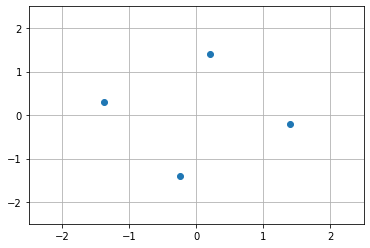

SNR: -4 BER: 0.33484
SNR: -3.5 BER: 0.31682
SNR: -3.0 BER: 0.29492
SNR: -2.5 BER: 0.27182
SNR: -2.0 BER: 0.24132
SNR: -1.5 BER: 0.22056
SNR: -1.0 BER: 0.19876
SNR: -0.5 BER: 0.17708
SNR: 0.0 BER: 0.15156
SNR: 0.5 BER: 0.13016
SNR: 1.0 BER: 0.1083
SNR: 1.5 BER: 0.09044
SNR: 2.0 BER: 0.07236
SNR: 2.5 BER: 0.06004
SNR: 3.0 BER: 0.04464
SNR: 3.5 BER: 0.03446
SNR: 4.0 BER: 0.0252
SNR: 4.5 BER: 0.01844
SNR: 5.0 BER: 0.01244
SNR: 5.5 BER: 0.00822
SNR: 6.0 BER: 0.00512
SNR: 6.5 BER: 0.00318
SNR: 7.0 BER: 0.00172
SNR: 7.5 BER: 0.0009
SNR: 8.0 BER: 0.0004


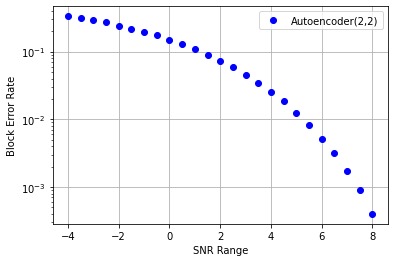

In [8]:

#generating data of size N
N = 8000
label = np.random.randint(M,size=N)

# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)

# checking data shape
data = np.array(data)
print (data.shape)


# checking generated data with it's label
temp_check = [17,23,45,67,89,96,72,250,350]
for i in temp_check:
    print(label[i],data[i])

# defining autoencoder and it's layer
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(n_channel, activation='linear')(encoded)
encoded2 = Lambda(lambda x: np.sqrt(n_channel)*K.l2_normalize(x,axis=1))(encoded1)

EbNo_train = 5.01187 #  coverted 7 db of EbNo
encoded3 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded2)

decoded = Dense(M, activation='relu')(encoded3)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model(input_signal, decoded1)
adam = Adam(lr=0.01)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')

# printing summary of layers and it's trainable parameters 
print (autoencoder.summary())

# for tensor board visualization
#tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

# traning auto encoder
autoencoder.fit(data, data,
                epochs=45,
                batch_size=32)

# saving keras model
from keras.models import load_model
# if you want to save model then remove below comment
# autoencoder.save('autoencoder_v_best.model')

# making encoder from full autoencoder
encoder = Model(input_signal, encoded2)

# making decoder from full autoencoder
encoded_input = Input(shape=(n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)


# generating data for checking BER
# if you're not using t-sne for visulation than set N to 70,000 for better result 
# for t-sne use less N like N = 1500
N = 50000
test_label = np.random.randint(M,size=N)
test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)


# checking generated data
temp_test = 6
print (test_data[temp_test][test_label[temp_test]],test_label[temp_test])

# for plotting learned consteallation diagram

scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
scatter_plot = np.array(scatter_plot)
print (scatter_plot.shape)


# use this function for ploting constellation for higher dimenson like 7-D for (7,4) autoencoder 
'''
x_emb = encoder.predict(test_data)
noise_std = np.sqrt(1/(2*R*EbNo_train))
noise = noise_std * np.random.randn(N,n_channel)
x_emb = x_emb + noise
from sklearn.manifold import TSNE
X_embedded = TSNE(learning_rate=700, n_components=2,n_iter=35000, random_state=0, perplexity=60).fit_transform(x_emb)
print (X_embedded.shape)
X_embedded = X_embedded / 7
import matplotlib.pyplot as plt
plt.scatter(X_embedded[:,0],X_embedded[:,1])
#plt.axis((-2.5,2.5,-2.5,2.5)) 
plt.grid()
plt.show()
'''

# ploting constellation diagram
import matplotlib.pyplot as plt
scatter_plot = scatter_plot.reshape(M,2,1)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.show()


def frange(x, y, jump):
  while x < y:
    yield x
    x += jump


# calculating BER
# this is optimized BER function so it can handle large number of N
# previous code has another for loop which was making it slow
EbNodB_range = list(frange(-4,8.5,0.5))
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    noise = noise_std * np.random.randn(nn,n_channel)
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal + noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber[n])
    # use below line for generating matlab like matrix which can be copy and paste for plotting ber graph in matlab
    #print(ber[n], " ",end='')

# ploting ber curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(2,2)')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)

# for saving figure remove below comment
#plt.savefig('AutoEncoder_2_2_constrained_BER_matplotlib')
plt.show()